## Notes

This is the first notebook that was ran on Google Colab, using the T4 TPU. The output are visible below.

The hyperparameters used are listed below as well. They aren't tweaked as much compared to their original values.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/UNIVERSITY/deep-learning-classifier-model/src

/content/drive/MyDrive/UNIVERSITY/deep-learning-classifier-model/src


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
import os
import copy
import time

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

data_dir = '../data/train'

full_dataset = datasets.ImageFolder(data_dir, data_transforms['train'])
train_size = int(0.7 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=10, shuffle=True, num_workers=0)
class_names = full_dataset.classes
dataloaders = {'train': train_loader, 'val': val_loader}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(class_names)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Define dataset_sizes
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

['Honda', 'Perodua', 'Proton', 'Toyota']


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]

                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

            else:
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]

                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model


In [ ]:
# HYPERPARAMETERS

LEARNING_RATE = 0.001
MOMENTUM = 0.9
STEP_SIZE = 7
GAMMA = 0.1
NUM_EPOCHS = 25


In [ ]:
model = models.resnet18(pretrained=True)
#model = models.resnet18(weights='imagenet')

num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=3)

model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=STEP_SIZE, gamma=GAMMA)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=NUM_EPOCHS)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/2
----------
train Loss: 1.2689 Acc: 0.4341
val Loss: 1.2663 Acc: 0.4233

Epoch 1/2
----------
train Loss: 1.0741 Acc: 0.5205
val Loss: 1.0436 Acc: 0.5714

Epoch 2/2
----------
train Loss: 0.9383 Acc: 0.6000
val Loss: 0.9962 Acc: 0.5608

Training complete in 7m 9s
Best val Acc: 0.571429
Epoch 0/24
----------
train Loss: 1.3934 Acc: 0.3432
val Loss: 1.2752 Acc: 0.4127

Epoch 1/24
----------
train Loss: 1.1920 Acc: 0.4841
val Loss: 1.3134 Acc: 0.4233

Epoch 2/24
----------
train Loss: 1.1722 Acc: 0.5068
val Loss: 1.1466 Acc: 0.5291

Epoch 3/24
----------
train Loss: 1.0753 Acc: 0.5955
val Loss: 1.2053 Acc: 0.5397

Epoch 4/24
----------
train Loss: 1.1092 Acc: 0.5114
val Loss: 1.1323 Acc: 0.5556

Epoch 5/24
----------
train Loss: 1.0241 Acc: 0.5955
val Loss: 1.1988 Acc: 0.4497

Epoch 6/24
----------
train Loss: 1.0057 Acc: 0.5705
val Loss: 1.1610 Acc: 0.4974

Epoch 7/24
----------
train Loss: 0.9923 Acc: 0.5727
val Loss: 1.0724 Acc: 0.6032

Epoch 8/24
----------
train Loss: 0.9549

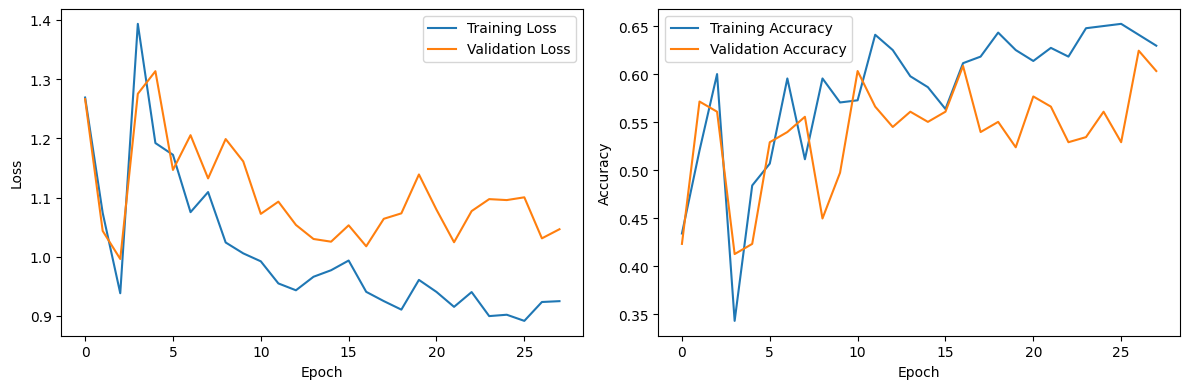

In [ ]:
# After training, plot the training and validation loss/accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()